<a href="https://colab.research.google.com/github/PARULCHUTANIPC/parul/blob/p1/Dogs%20Vs%20Cats%20Filtered%20dataset%20(working).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
from tensorflow import keras

In [0]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import backend as K
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
%matplotlib inline

## **PREPARING THE DATASET**

**Generating the images using image data generator**

In [0]:
import os
import zipfile

local_zip = '/content/drive/My Drive/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall()
zip_ref.close()

In [0]:
base_dir = '/content/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')



In [0]:
# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

**Checking the image format - Channels-width-hight or  width-height-channels**

In [0]:
if K.image_data_format() == 'channels_first':
  input_shape = (3, 224, 224)
else:
  input_shape = (224, 224, 3)

In [40]:
# Adding rescale, rotation_range, width_shift_range, height_shift_range,
# shear_range, zoom_range, and horizontal flip to our ImageDataGenerator

training_data_generation = ImageDataGenerator(
    rotation_range=90,
    shear_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    rescale=1/255,
    zoom_range=0.4)

test_data_generation = ImageDataGenerator(rescale=1/255)


# Flow training images in batches of 32 using train_datagen generator
train_generator = training_data_generation.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(224, 224),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 32 using val_datagen generator
validation_generator = test_data_generation.flow_from_directory(
        validation_dir,
        target_size=(224, 224),
        batch_size=20,
        class_mode='binary')



Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [41]:
print(train_generator.class_indices)


{'cats': 0, 'dogs': 1}


In [0]:
test_images, test_labels = next(validation_generator)
#imgs, labels = next(train_generator)

In [0]:
from skimage import io

def imshow(image_RGB):
  io.imshow(image_RGB)
  io.show()

20
0.0  random images from the training dataset


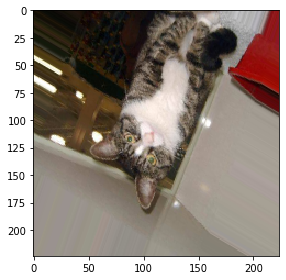

0.0  random images from the training dataset


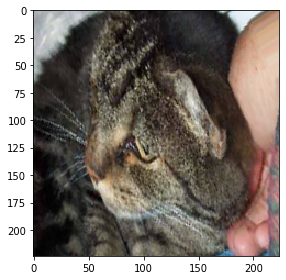

1.0  random images from the training dataset


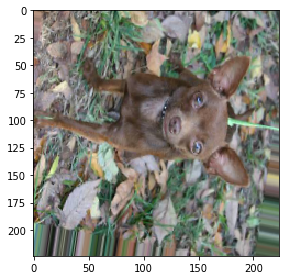

0.0  random images from the training dataset


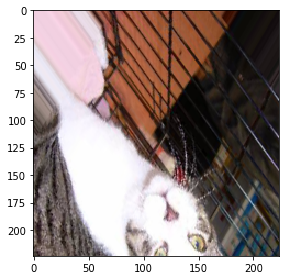

0.0  random images from the training dataset


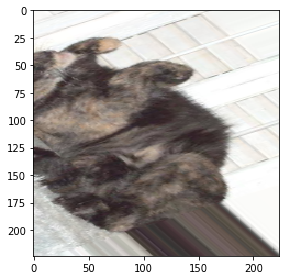

1.0  random images from the training dataset


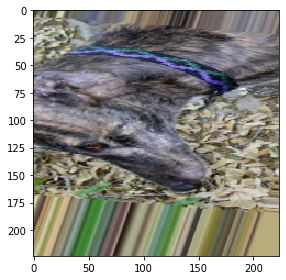

0.0  random images from the training dataset


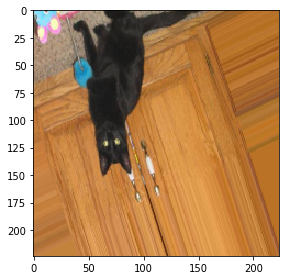

1.0  random images from the training dataset


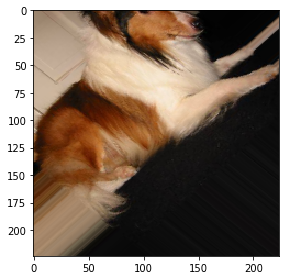

0.0  random images from the training dataset


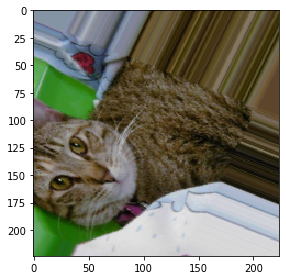

0.0  random images from the training dataset


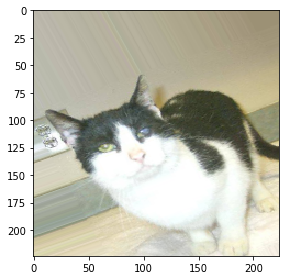

1.0  random images from the training dataset


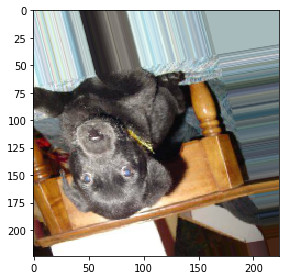

1.0  random images from the training dataset


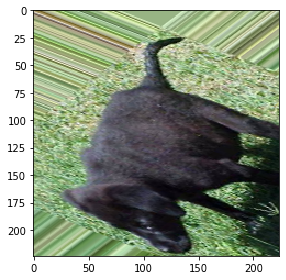

0.0  random images from the training dataset


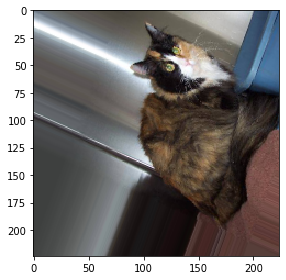

1.0  random images from the training dataset


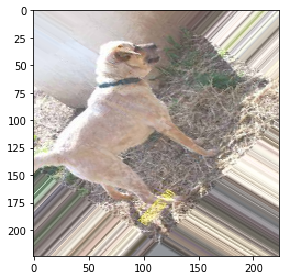

1.0  random images from the training dataset


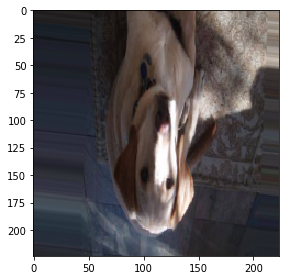

0.0  random images from the training dataset


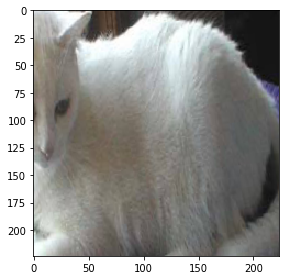

0.0  random images from the training dataset


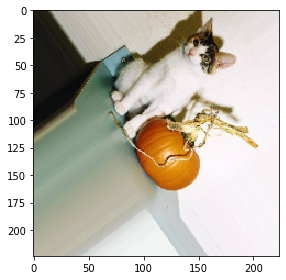

0.0  random images from the training dataset


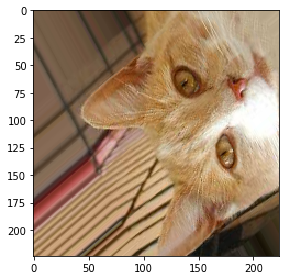

0.0  random images from the training dataset


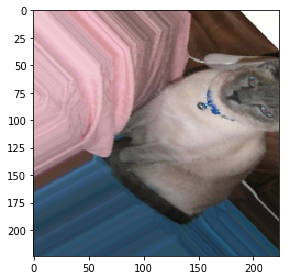

1.0  random images from the training dataset


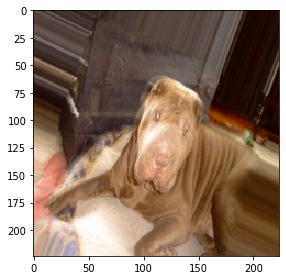

In [44]:
train_images,train_labels = train_generator.next()

print(len(train_images))
for i in range(0,len(train_images)):
    image = train_images[i]
    print(train_labels[i], " random images from the training dataset")
    imshow(image)

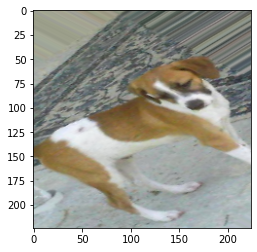

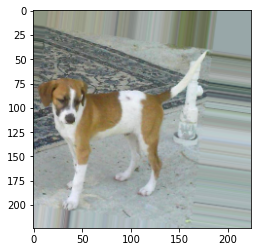

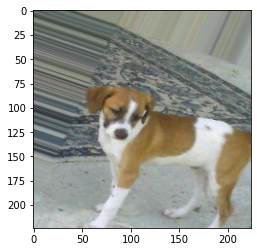

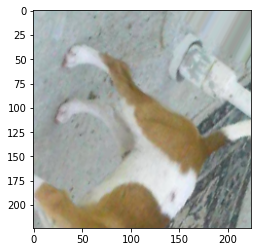

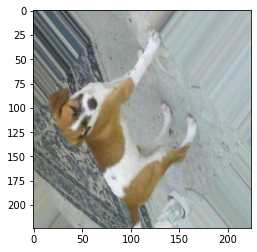

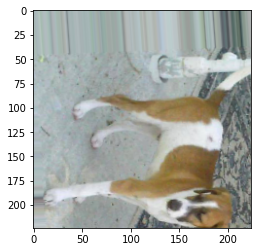

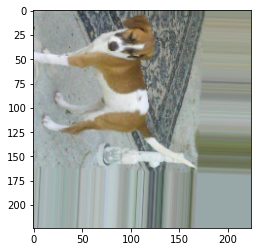

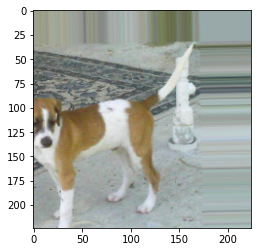

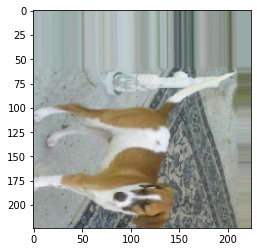

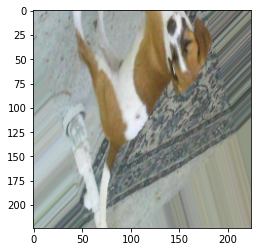

In [45]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img

img_path = os.path.join(train_dogs_dir, train_dog_fnames[0])
img = load_img(img_path, target_size=(224, 224))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (224, 224, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 224, 224, 3)

# The .flow() command below generates batches of randomly transformed images
# It will loop indefinitely, so we need to `break` the loop at some point!
i = 0
for batch in training_data_generation.flow(x, batch_size=1):
  plt.figure(i)
  imgplot = plt.imshow(array_to_img(batch[0]))
  i += 1
  if i % 10 == 0:
    break

## **PREPARING THE VGG16 MODEL**

**Importing the model**

In [0]:
vgg16 = keras.applications.vgg16.VGG16()

In [47]:
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

**Removing the output layer**

In [48]:
baseModel = VGG16(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))
# show a summary of the base model
print("[INFO] summary for base model...")
print(baseModel.summary())

[INFO] summary for base model...
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)  

**Adding the output layer according to dataset**

In [57]:
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output


#headModel = tf.keras.AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
#headModel = Dropout(0.5)(headModel)

headModel = Dense(2, activation="softmax")(headModel)
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

**Compiling the Model**

In [58]:
# compile our model (this needs to be done after our setting our
# layers to being non-trainable)
print("[INFO] compiling model...")
opt = tf.keras.optimizers.Adam(lr=1e-4)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

[INFO] compiling model...


## **TRAINING THE MODEL**

In [0]:
train_samples = 120
validation_samples = 30
epochs = 5
batch_size = 20

In [60]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=10,
      epochs=5,
      validation_data=validation_generator,
      validation_steps=10,
      verbose=1)

Epoch 1/5
10/10 [==============================] - 191s 19s/step - loss: 0.8535 - accuracy: 0.5250 - val_loss: 0.8498 - val_accuracy: 0.5350
Epoch 2/5
10/10 [==============================] - 190s 19s/step - loss: 0.7331 - accuracy: 0.4550 - val_loss: 0.7317 - val_accuracy: 0.5000
Epoch 3/5
10/10 [==============================] - 194s 19s/step - loss: 0.7154 - accuracy: 0.5100 - val_loss: 0.7027 - val_accuracy: 0.4900
Epoch 4/5
10/10 [==============================] - 190s 19s/step - loss: 0.7065 - accuracy: 0.5000 - val_loss: 0.7030 - val_accuracy: 0.4800
Epoch 5/5
10/10 [==============================] - 191s 19s/step - loss: 0.7025 - accuracy: 0.4600 - val_loss: 0.7009 - val_accuracy: 0.4900


**Saving the weights & model**

In [0]:
model.save_weights("dogs-cats-try1.h5")

**Selecting 1 image to verify the working of model**

In [0]:
image_pred = image.load_img("       ",target size = (224,224))
image_pred = image.img_to_array(image_pred)
image_pred = np.expand_dims(image_pred, axis = 0)

**Testing the single uploaded image & Verify the result**

In [0]:
result = model.predict(image_pred)
print(image_pred)
if result[0][0] ==1:
  prediction = "This is a Dog"
else:
  prediction = "This is a Cat"
print(prediction)

In [62]:
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

NameError: ignored

Text(0.5, 1.0, 'Training and validation loss')

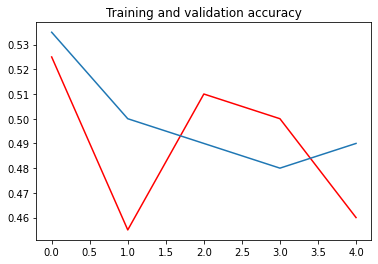

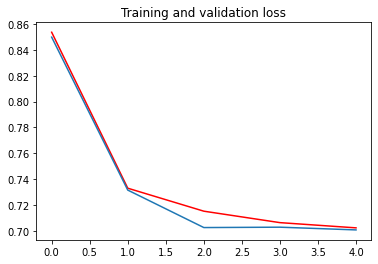

In [68]:
# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')